## Séries temporais estacionárias: prevsião pela média

Este notebook busca uma série temporal de um arquivo escolhido e faz algumas análises preliminares, bem como a aplicação do modelo de previsão pela média dos valores conhecidos.

Data da última atualização: 17/02/2025

#### Preliminares

In [1]:
# Carregamento das bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Ajuste das preferências gráficas

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#FFFFFF',    # Cor da moldura
    'axes.facecolor': '#FFFFFF',      # Cor do fundo
    'savefig.facecolor':'#000000',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'grid.color': '#888888',
    'grid.linewidth': '0.1',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (21,13)

#### Carregamento da Série Temporal

In [3]:
# Leitura do arquivo de dados

MinhaSerieTemporal = pd.read_csv('Passageiros.csv', index_col = 0)

In [4]:
# Exibição do DataFrame

MinhaSerieTemporal

,Passageiros (milhares)
Mês,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
# Ajuste do índice para formato DateTime

MinhaSerieTemporal.index = pd.to_datetime(MinhaSerieTemporal.index)

<Axes: xlabel='Mês'>

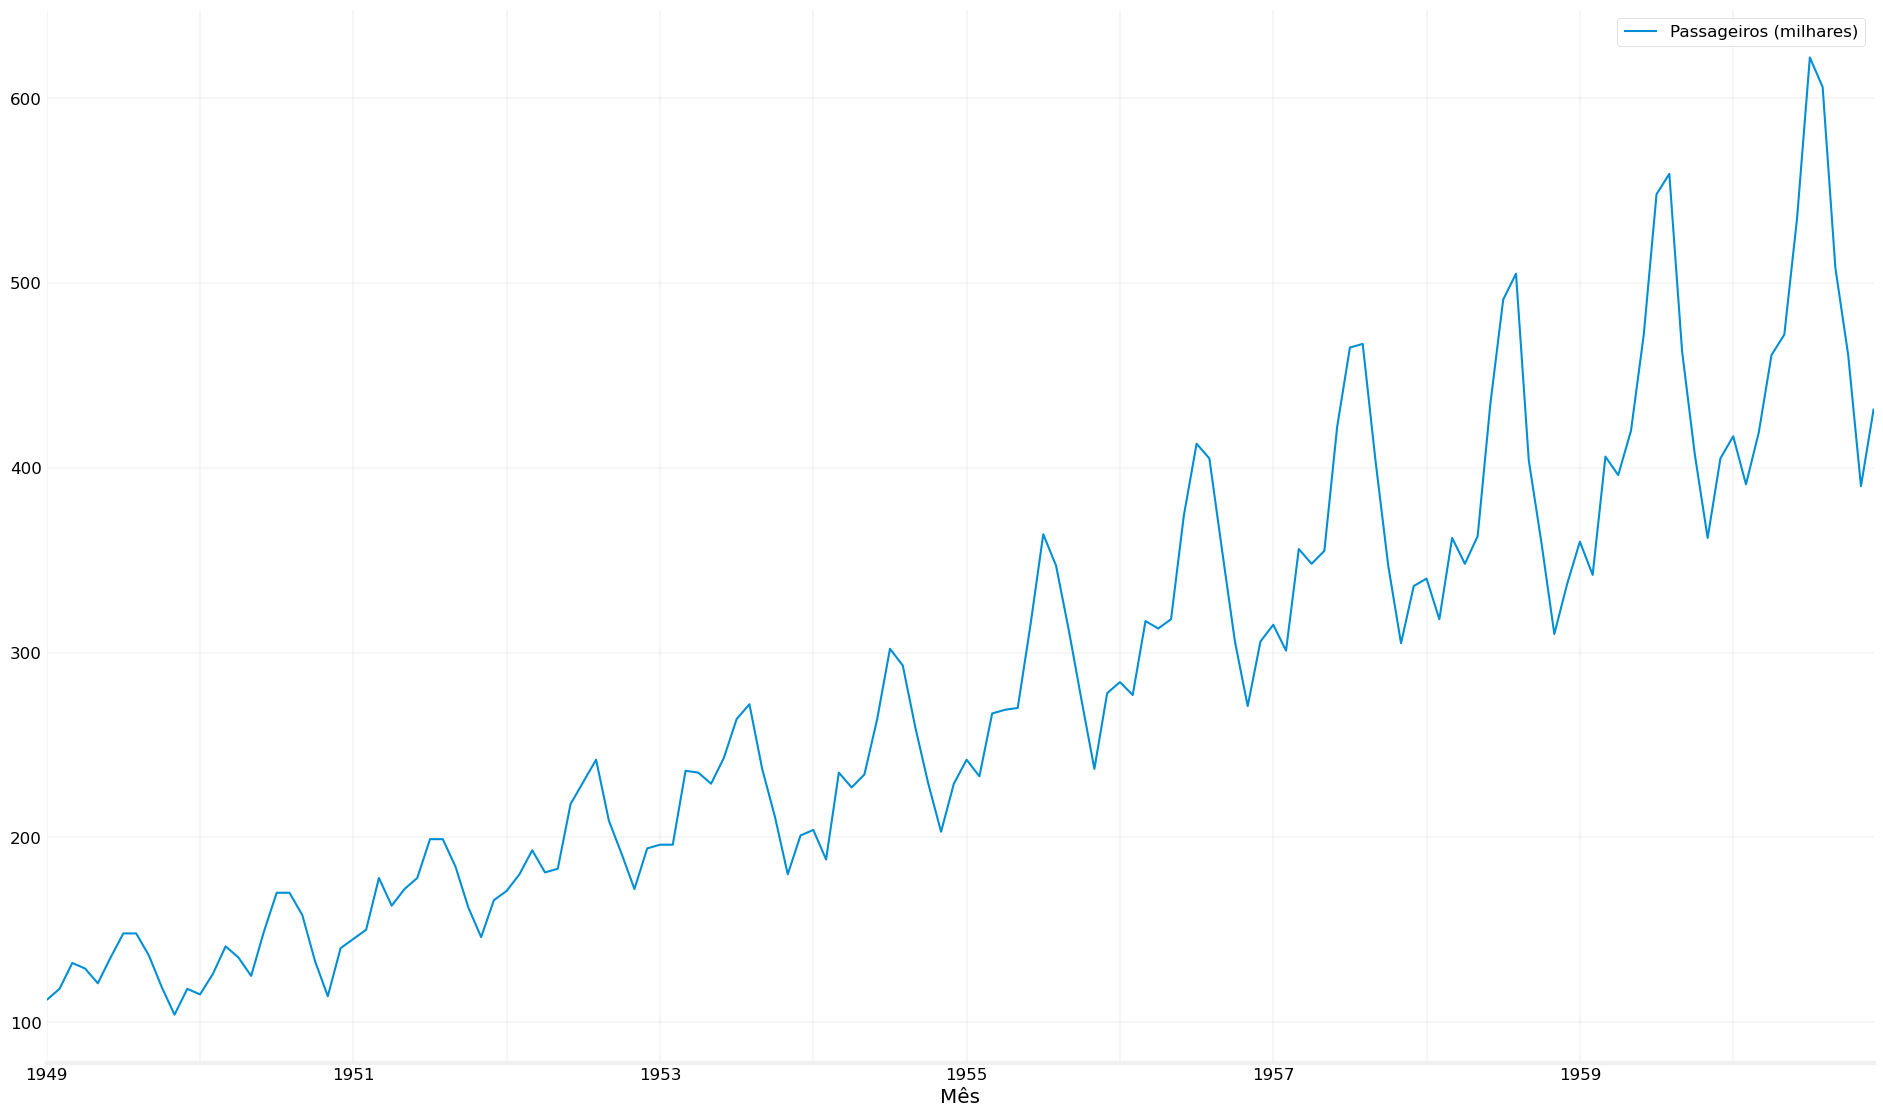

In [6]:
# Gráfico
MinhaSerieTemporal.plot()

#### Decomposição da Série

In [7]:
# Decomposição aditiva da série temporal

PeriodoSazonal = 12     # Sazonalidade anual

Decomposicao = seasonal_decompose(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], model = "add", period = PeriodoSazonal)

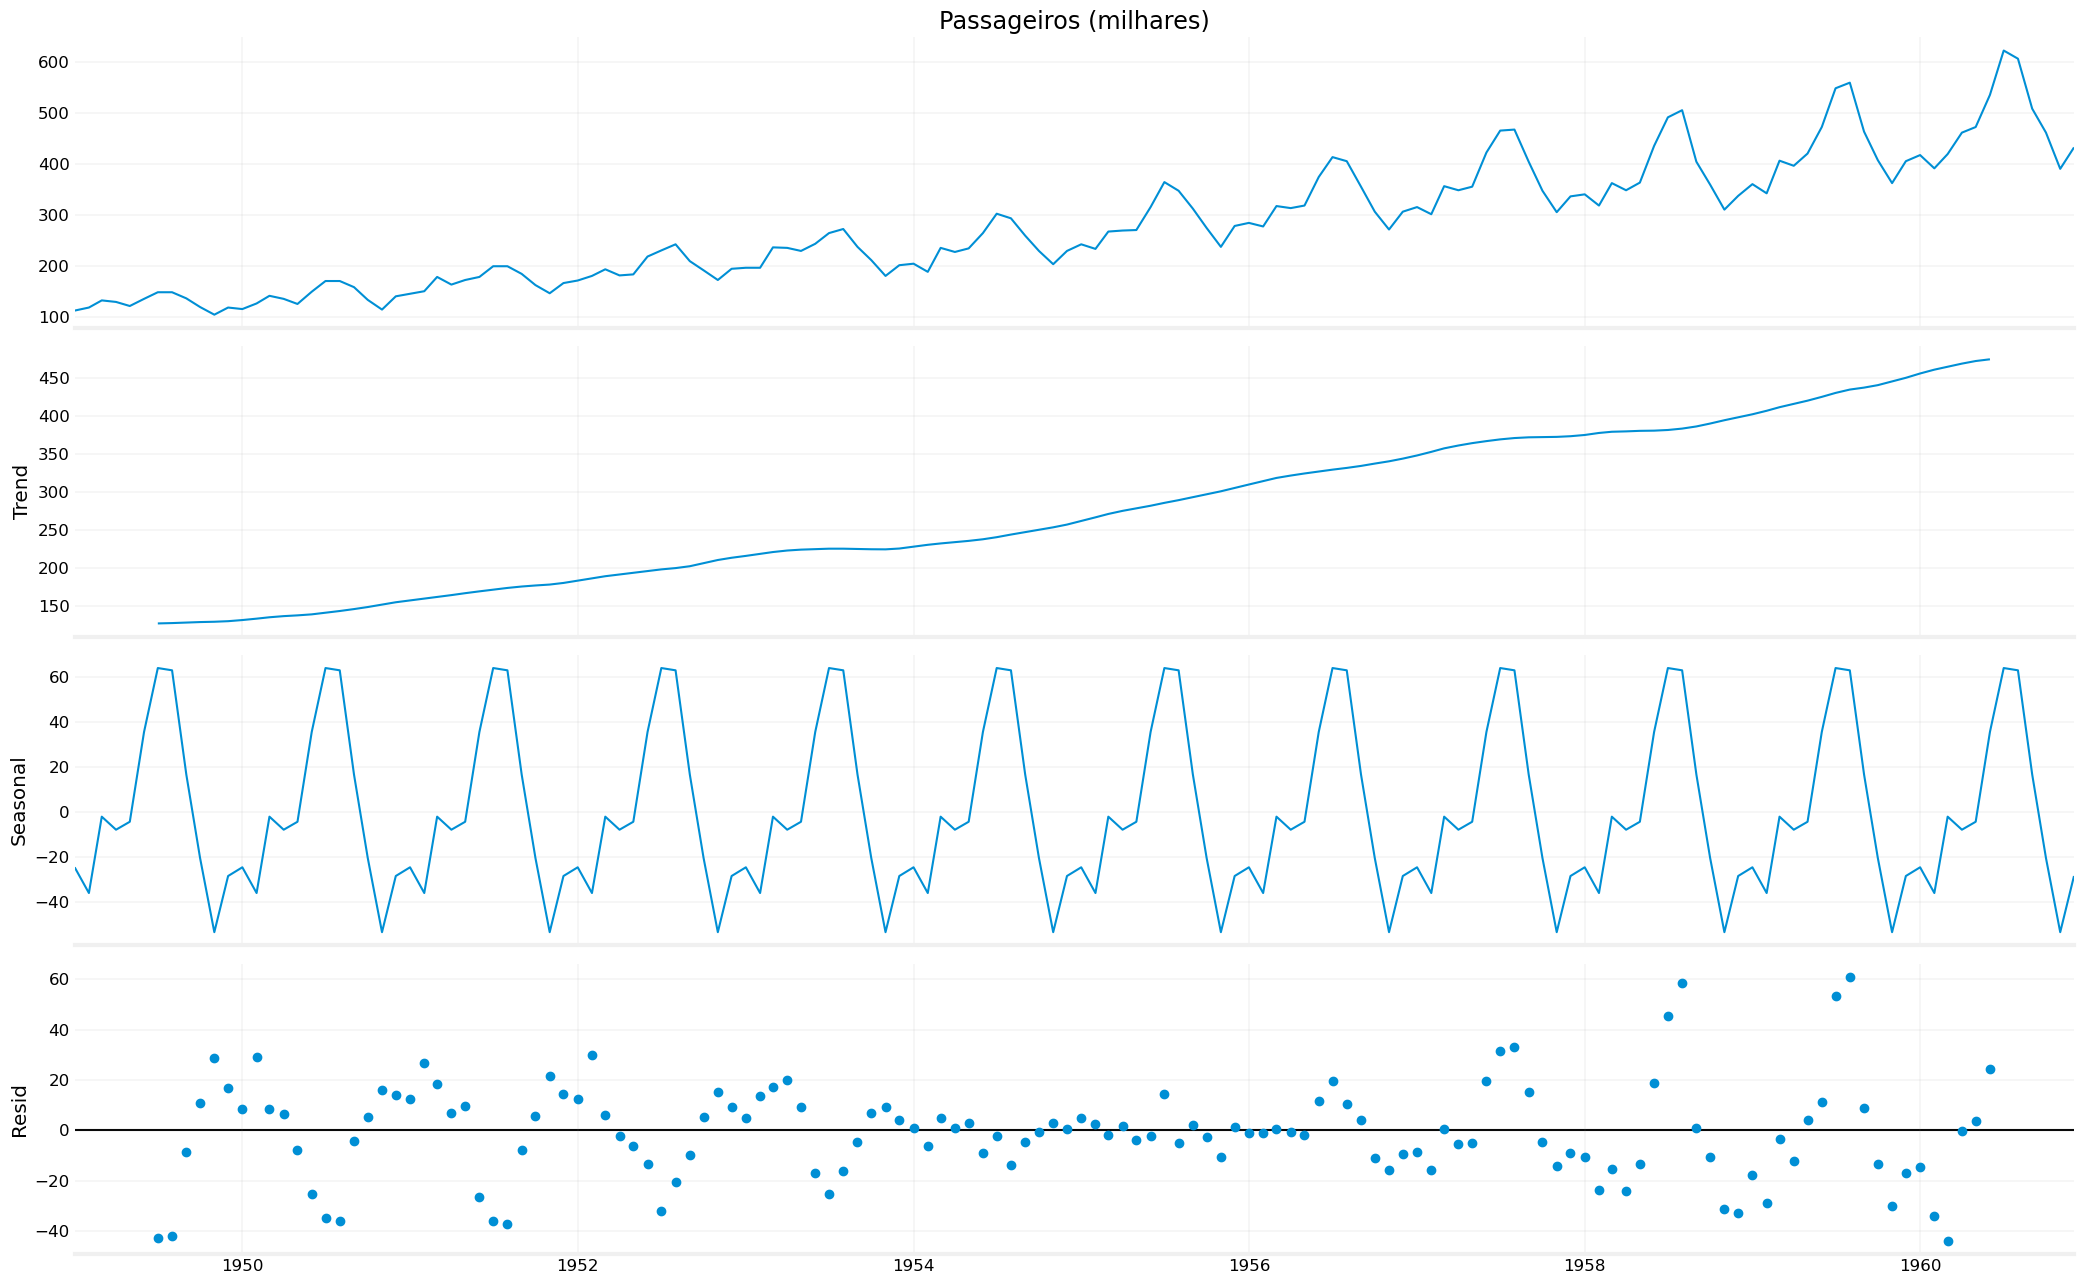

In [8]:
Decomposicao.plot();

#### Teste ADF

In [9]:
# Teste ADF para estacionariedade

ad_fuller_result = adfuller(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]])

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: 0.8154
p-value:          99.1880 %


In [10]:
# Teste ADF para estacionariedade para a série das diferenças finitas de ordem escolhida

OrdemDif = 2

ad_fuller_result = adfuller(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif))

print(f'Estatística ADF: {ad_fuller_result[0]:2.4f}')
print(f'p-value:         {ad_fuller_result[1]*100: 2.4f} %')

Estatística ADF: -16.3842
p-value:          0.0000 %


#### Funcão de autocorrelação

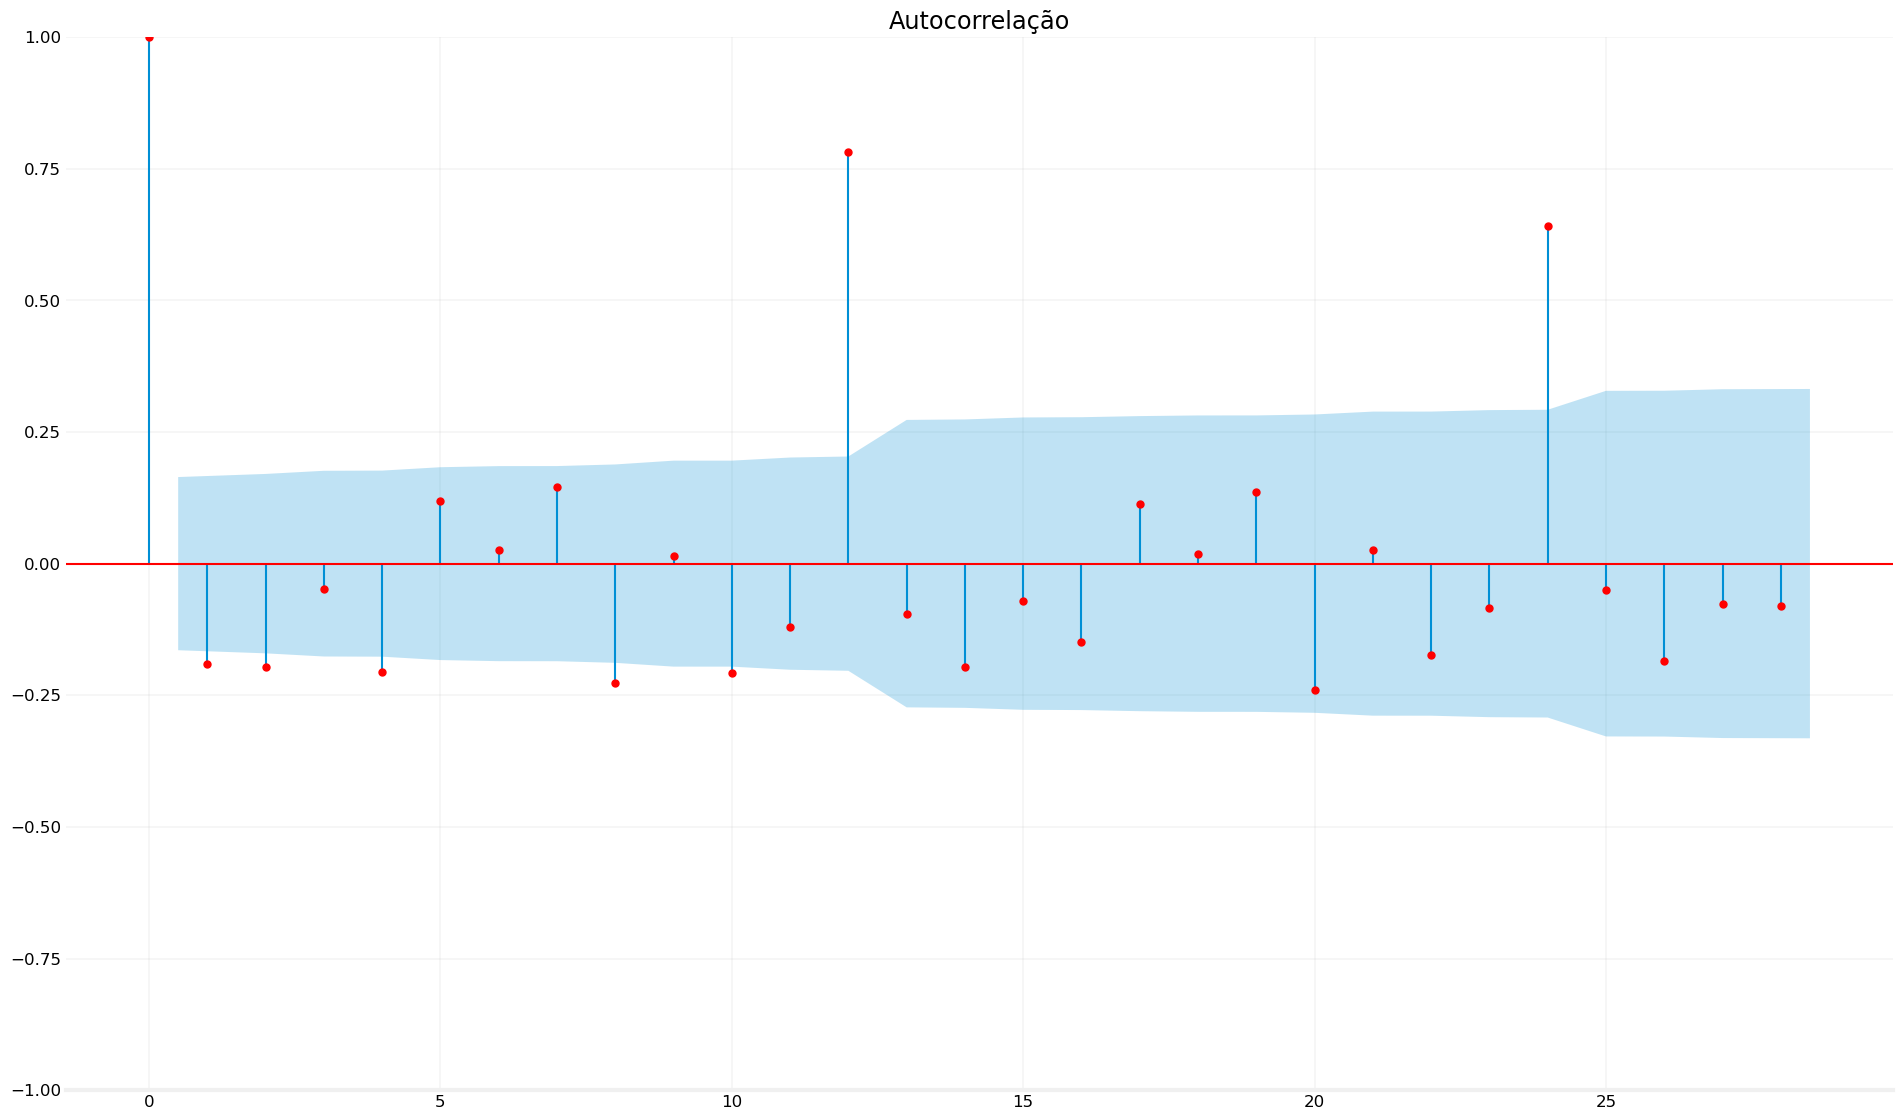

In [11]:
# Função de correlação para série temporal

plot_acf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=28, title = "Autocorrelação", color="red");

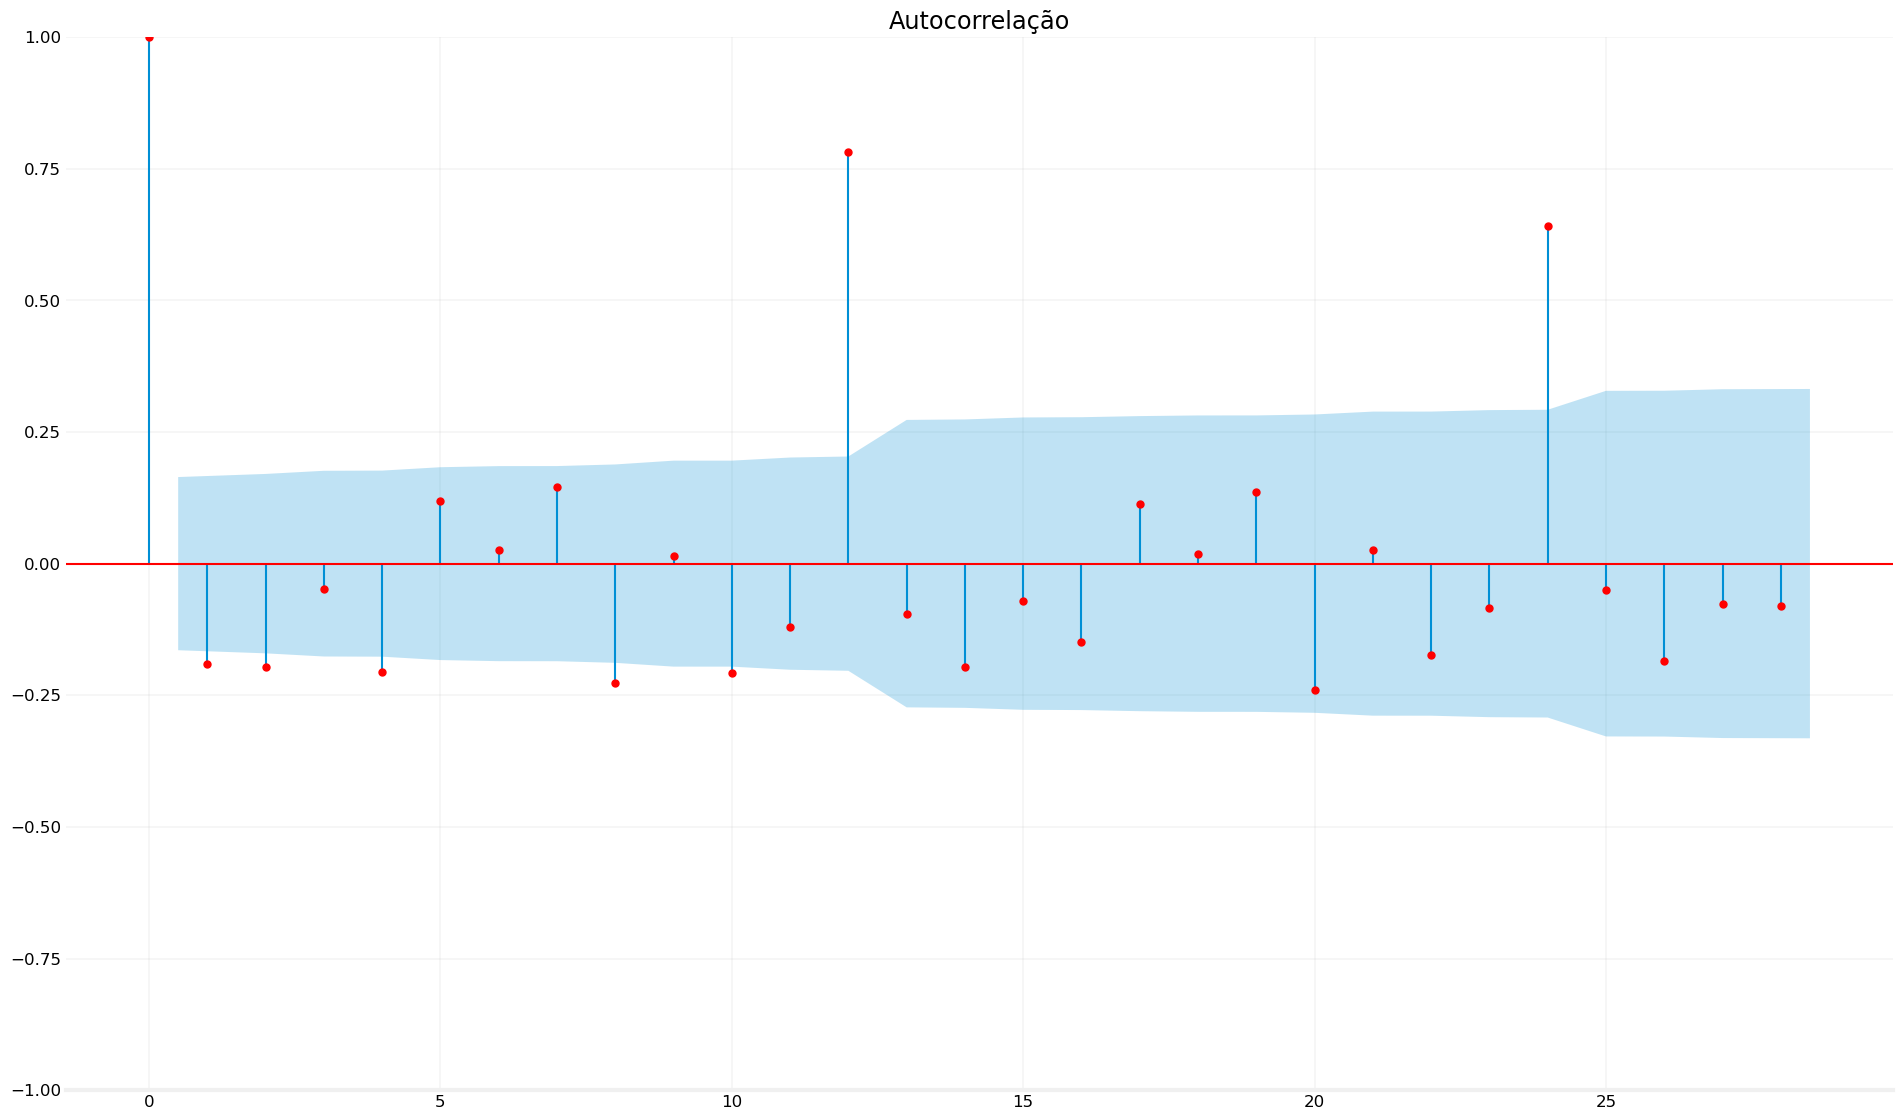

In [12]:
# Função de correlação para série das diferenças finitas da ordem escolhida acima

plot_acf(np.diff(MinhaSerieTemporal[MinhaSerieTemporal.columns[0]], n = OrdemDif),  lags=28, title = "Autocorrelação", color="red");

#### Separação das bases de treino e teste

In [13]:
# Definição da proporção de dados para compor a base de teste

PercentualTeste = 10

In [14]:
# Cálculo do tamanho do período de testes
PeriodoTeste = PercentualTeste * len(MinhaSerieTemporal) // 100

# Definição do DataFrame de treino
TreinoDF = pd.DataFrame(index = MinhaSerieTemporal[:-PeriodoTeste].index)
TreinoDF['Treino'] = MinhaSerieTemporal[:-PeriodoTeste][MinhaSerieTemporal.columns[0]]

# Definição do DataFrame de teste
TesteDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
TesteDF['Teste'] = MinhaSerieTemporal[-PeriodoTeste:][MinhaSerieTemporal.columns[0]]

<Axes: xlabel='Mês'>

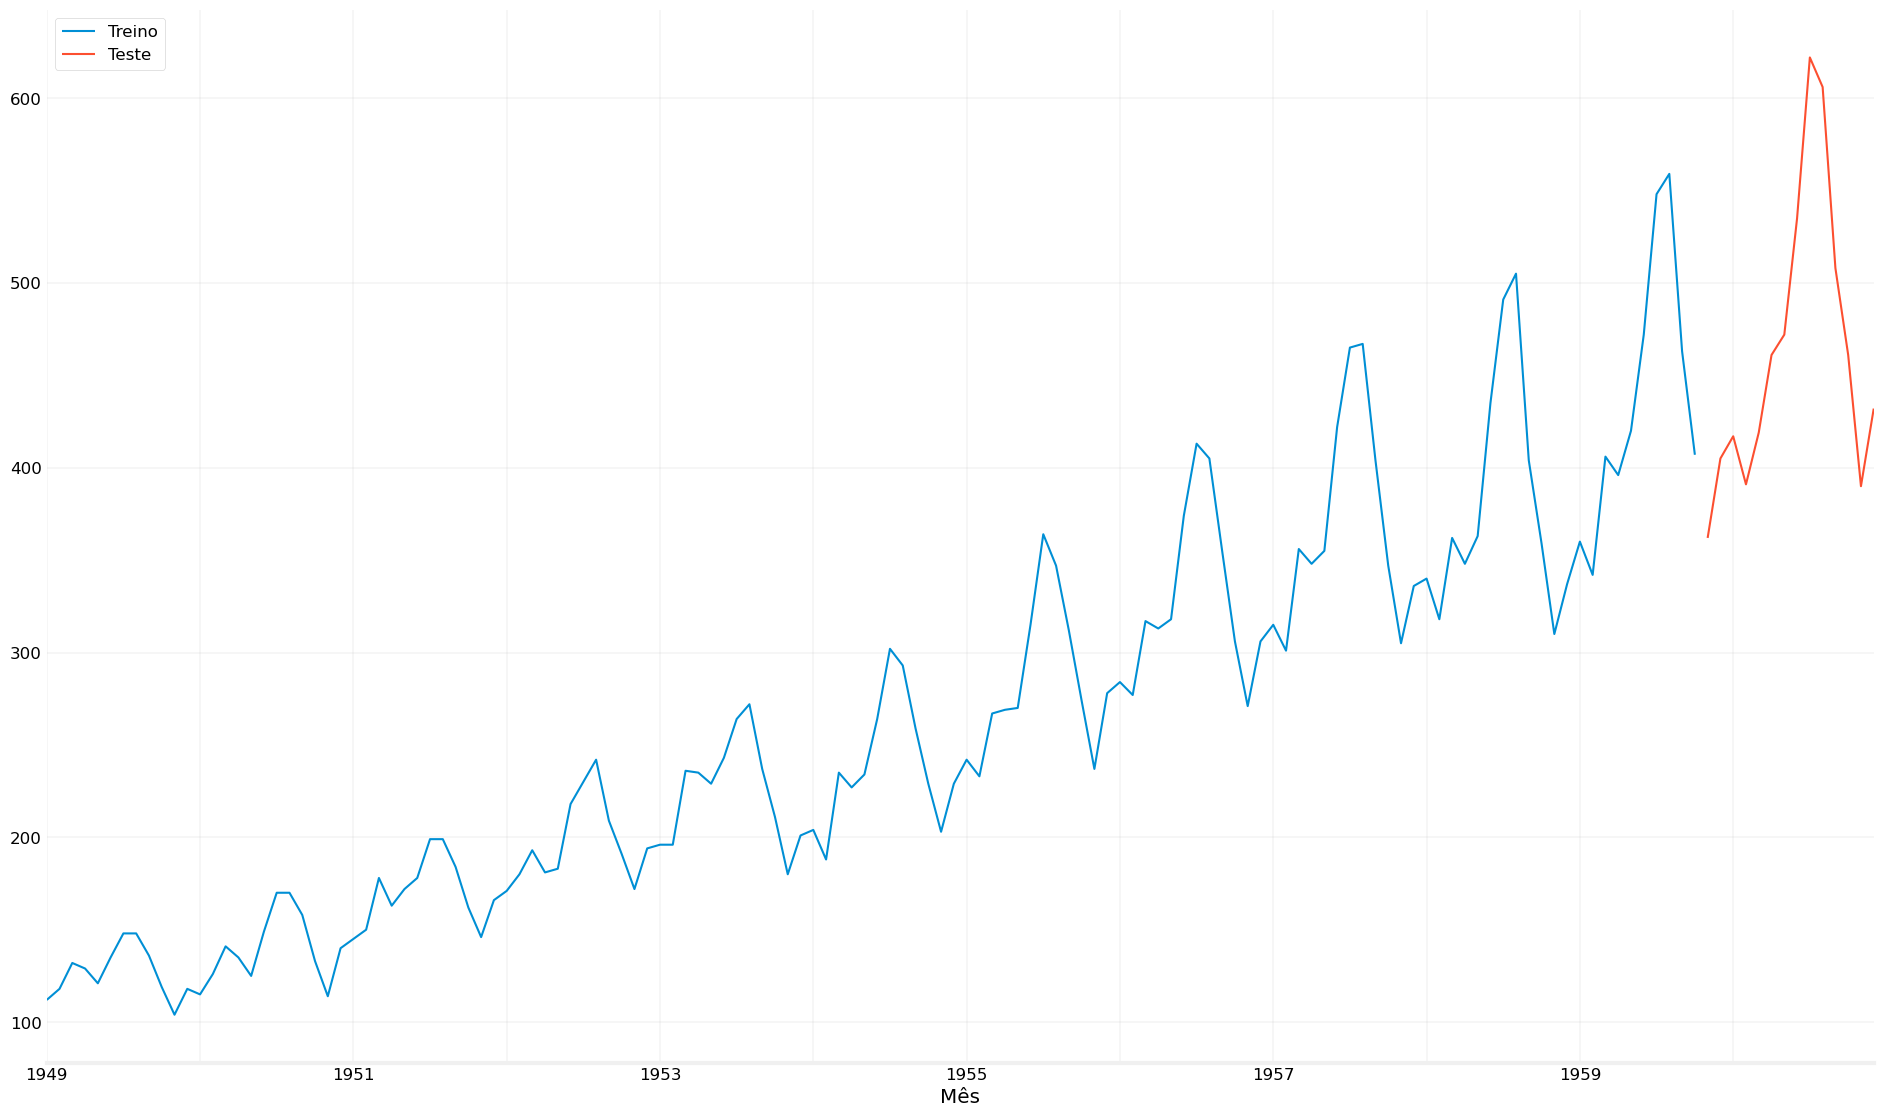

In [15]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([TreinoDF,TesteDF], axis = 1).plot()

#### Previsão pela média

In [16]:
# Cálculo da média dos valores da série temporal na base de treino 

MediaTreino = TreinoDF['Treino'].mean()

In [17]:
# Montagem do DataFrame de previsão

PrevisoesDF  = pd.DataFrame(index = MinhaSerieTemporal[-PeriodoTeste:].index)
PrevisoesDF['Previsão'] = MediaTreino * np.ones(len(PrevisoesDF.index))

<Axes: xlabel='Mês'>

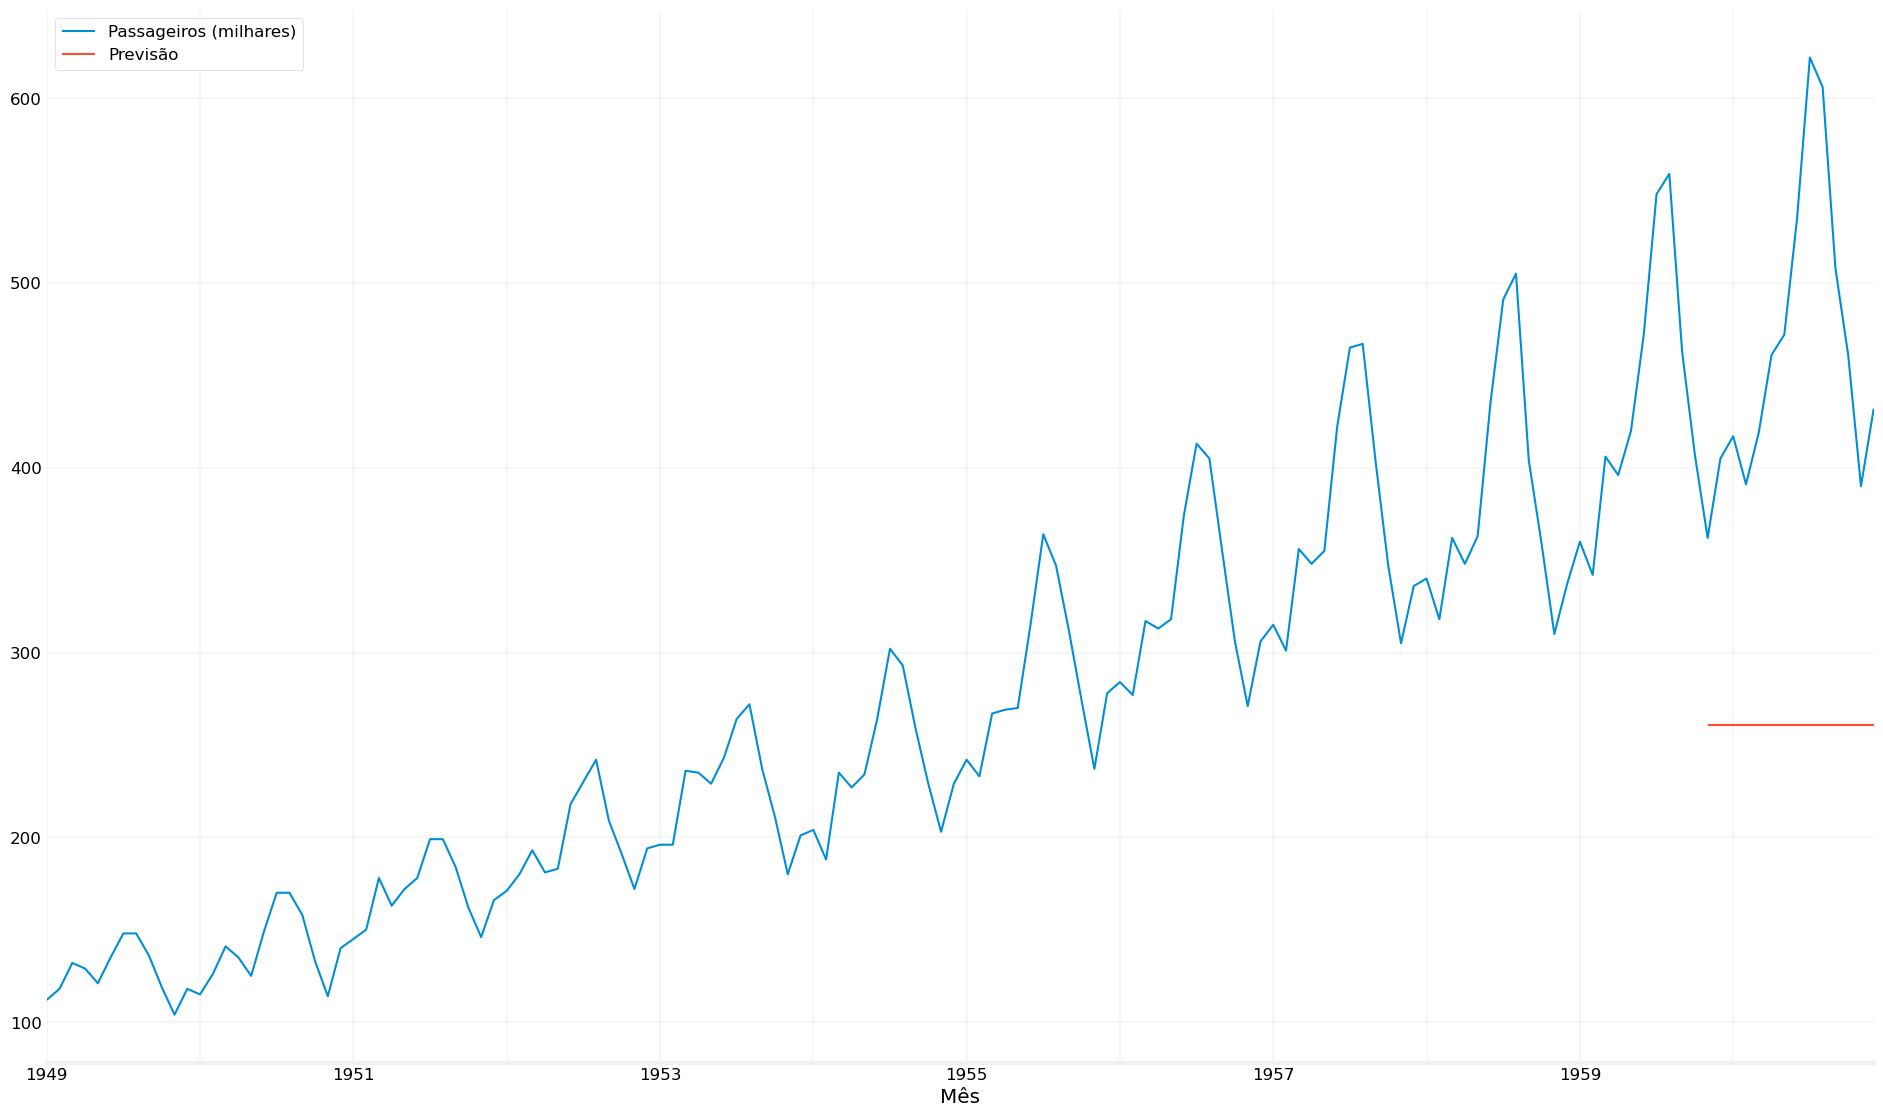

In [18]:
# Exibe a série temporal, com a separação da base de dados

pd.concat([MinhaSerieTemporal,PrevisoesDF], axis = 1).plot()

#### Medidas de erro

In [19]:
# Cáluclo do vetor de erros

Erros = PrevisoesDF['Previsão'].values - TesteDF['Teste'].values
Erros

array([-101.36923077, -144.36923077, -156.36923077, -130.36923077,
       -158.36923077, -200.36923077, -211.36923077, -274.36923077,
       -361.36923077, -345.36923077, -247.36923077, -200.36923077,
       -129.36923077, -171.36923077])

In [20]:
# Cálculo do erro médio
ErroMedio = Erros.mean()

In [21]:
# Cálculo do erro absoluto médio
MAE = np.abs(Erros).mean()

In [22]:
# Cálculo da raiz do erro quadrático médio
RMSE = np.sqrt((Erros**2).mean())

In [23]:
# Cálculo dos erros relativos
ErrosRelativos = Erros / TesteDF['Teste'].values
ErrosRelativos

array([-0.2800255 , -0.35646724, -0.37498616, -0.33342514, -0.37796952,
       -0.43464041, -0.44781617, -0.51283968, -0.58097947, -0.56991622,
       -0.4869473 , -0.43464041, -0.33171598, -0.39668803])

In [24]:
# Cálculo do erro percentual absoluto médio
MAPE = np.abs(ErrosRelativos).mean()

In [25]:
print(f'Medidas de erro de previsão')
print()
print(f'Modelo de previsão: média dos valores conhecidos')
print()
print(f'Erro médio: {ErroMedio: 2.1f}')
print(f'MAE:        {MAE: 2.1f}')
print(f'RMSE:       {RMSE: 2.1f}')
print(f'MAPE:       {MAPE*100: 2.1f} %')

Medidas de erro de previsão

Modelo de previsão: média dos valores conhecidos

Erro médio: -202.3
MAE:         202.3
RMSE:        216.3
MAPE:        42.3 %
